In [1]:
import pandas as pd
import numpy as np
!pip install mne
import mne

from mne import Epochs, pick_types
from mne.preprocessing import ICA
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from mne.decoding import UnsupervisedSpatialFilter
from mne.viz import plot_topomap


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\AarPi\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [70]:
from datetime import datetime, timezone, timedelta
import pytz

Creating RawArray with float64 data, n_channels=23, n_times=504527
    Range : 0 ... 504526 =      0.000 ...  1978.533 secs
Ready.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


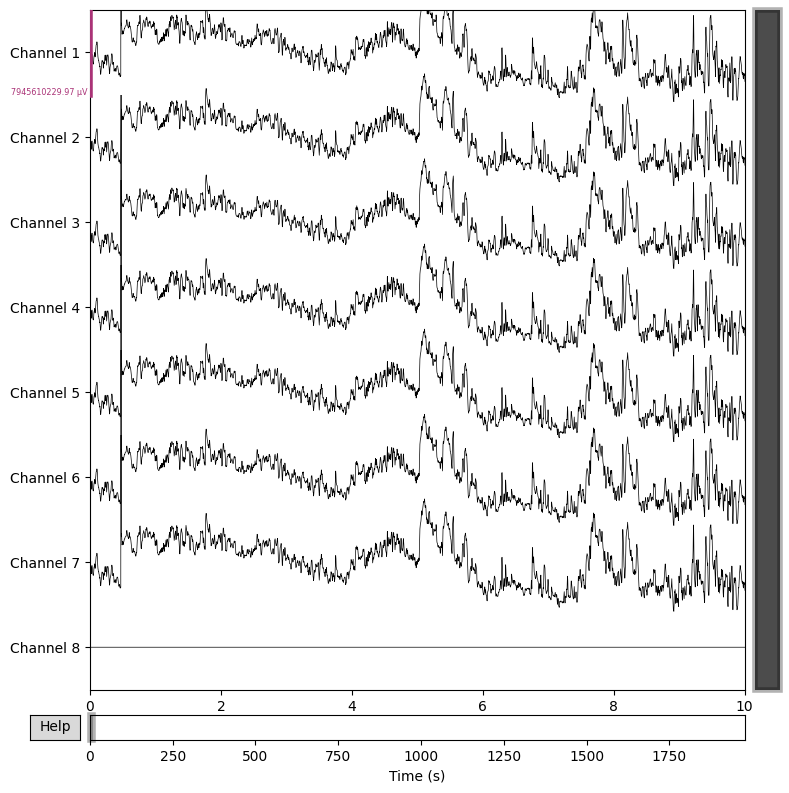

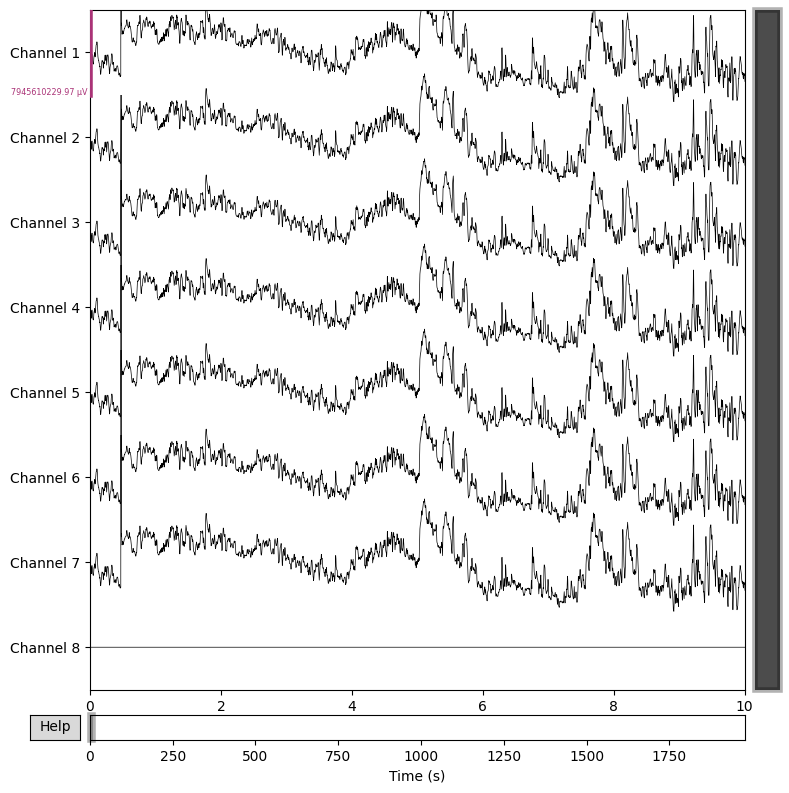

In [91]:
### Step 1. Load data ###
# to load data using pandas
# file path to one csv file, merge csv files later?
eeg_file_path_csv = '../raw_EEG_data/BrainFlow-RAW_2025-02-23_14-24-48_1.csv'

#load csv into a pandas df
df = pd.read_csv(eeg_file_path_csv, sep='\t', skiprows=2, header=None)

#drop rows with missing values
df.fillna(0.0, inplace=True)

#extract eeg data
trial_data = df.iloc[:, 1:24].values

# Declares channel names and types of each set of data
sfreq = 255  # sample rate in Hz
ch_names = ['Channel {}'.format(i) for i in range(trial_data.shape[1])]
ch_types = ['eeg' for i in range(trial_data.shape[1])]

# unix data is in the 21st column

def unix_to_utc(unix_timestamp):
    utc_time = datetime.utcfromtimestamp(unix_timestamp).replace(tzinfo=timezone.utc)

    local_timezone = pytz.timezone('America/Los_Angeles')
    local_time = utc_time.astimezone(local_timezone)
    return utc_time
    
eeg_start_time_unix = trial_data[0][21]

meas_date = unix_to_utc(eeg_start_time_unix)

# Create info structures and RawArray objects for each set of data
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_meas_date(meas_date)
raw = mne.io.RawArray(trial_data.T, info)

# Removing irrelevant channels
ch_names = [raw.ch_names]
ch_names_to_keep = [ch_names[0][1:9]]
raw = raw.pick_channels(ch_names_to_keep[0])

# Now you can work with the MNE Raw object
# print(raw.info)
# print(raw.get_data())

# # Plot the specified interval
raw.plot(scalings='auto')


In [92]:
#converts psychopy form to unix
def psychopy_to_unix(psychopy_time):
    # Define the format of the input timestamp
    format_string = "%Y-%m-%d %Hh%M.%S.%f %z"

    # Parse the custom timestamp into a datetime object
    parsed_timestamp = datetime.strptime(custom_timestamp, format_string)

    # Convert the datetime object to a Unix timestamp (floating-point for microseconds)
    unix_timestamp = parsed_timestamp.timestamp()

    # Print the Unix timestamp
    return(unix_timestamp)

In [93]:
### ADD ANNOTATIONS ####

#read in psychopy data
psyhcopy_file_path_csv = '../raw_PsychoPy_data/123_finaltest_2025-02-23_14h57.40.473.csv'

psychopy_df = pd.read_csv(psyhcopy_file_path_csv, delimiter=',', skiprows=0, header=0)

#create a new column for the unix time of psychopy stimuli
psychopy_df["unix_time"] = psychopy_df["expStart"].apply(time_conversion)

psychopy_df.head()

#annotations
# raw.annotations.rename(dict(T1="hands", T2="feet"))  #if ID = T1 rename to hands, do the same for feet. just makes it easier to read
# raw.set_eeg_reference(projection=True)  #dont worry


,symbols,amharic_set1,words_set1,amharic_set2,words_set2,amharic_set3,words_set3,amharic_set4,words_set4,amharic_practices,...,text_6.started,participant,session,date,expName,psychopyVersion,frameRate,expStart,Unnamed: 494,unix_time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09
1,✓,ቮ,cats,ኈ,fishing,ሐ,go,ና,dance,፨,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09
2,✗,ተ,north,ኴ,book,ሜ,artist,ኞ,education,፻,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09
3,NaN,ቺ,map,ዄ,mirror,ሣ,ring,ኧ,smart,ቇ,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09
4,NaN,ኇ,travel,ጕ,happy,ሯ,downtown,ኬ,late,ሏ,...,NaN,123.0,1.0,2025-02-23_14h57.40.473,finaltest,2024.2.4,59.998836,2025-02-23 14h58.10.741490 -0800,NaN,1.740351e+09


In [ ]:
#format of time in the psychopy csv file
time_format = "%Y-%m-%d %H:%M:%S.%f"

#new_orig_time = when psychopy started after the openbci

#create a buffer for when psychopy started after openbci
buffer = psychopy_df.loc[0, 'unix_time'] - eeg_start_time_unix

print(eeg_start_time_unix)
print(psychopy_df.loc[0, 'unix_time'])
print(buffer)

new_orig_time = (meas_date + timedelta(seconds=buffer)).strftime(time_format)

print(new_orig_time) 

later_annot = mne.Annotations(
    onset=[3, 5, 7],                    #onset, in seconds, when stimuli was shown
    duration=[1, 0.5, 0.25],            #how long they lasted
    description=["DDD", "EEE", "FFF"],  #names for the stimuli
    orig_time=new_orig_time,            #syncing psychopy start time and openbci start time
)

#TO DO
# make a list of onsets
# list of durations
# tags for all of them

raw2 = raw.copy().set_annotations(later_annot)
print(later_annot.onset)
print(raw2.annotations.onset)


1740351367.289244
1740351490.74149
123.45224595069885
2025-02-23 22:58:10.741490
[3. 5. 7.]
[126.452246 128.452246 130.452246]


EEG data time range: 0 to 1978.5333333333333 seconds
Annotations in raw2: <Annotations | 3 segments: DDD (1), EEE (1), FFF (1)>
Adjusted onsets: [3. 5. 7.]


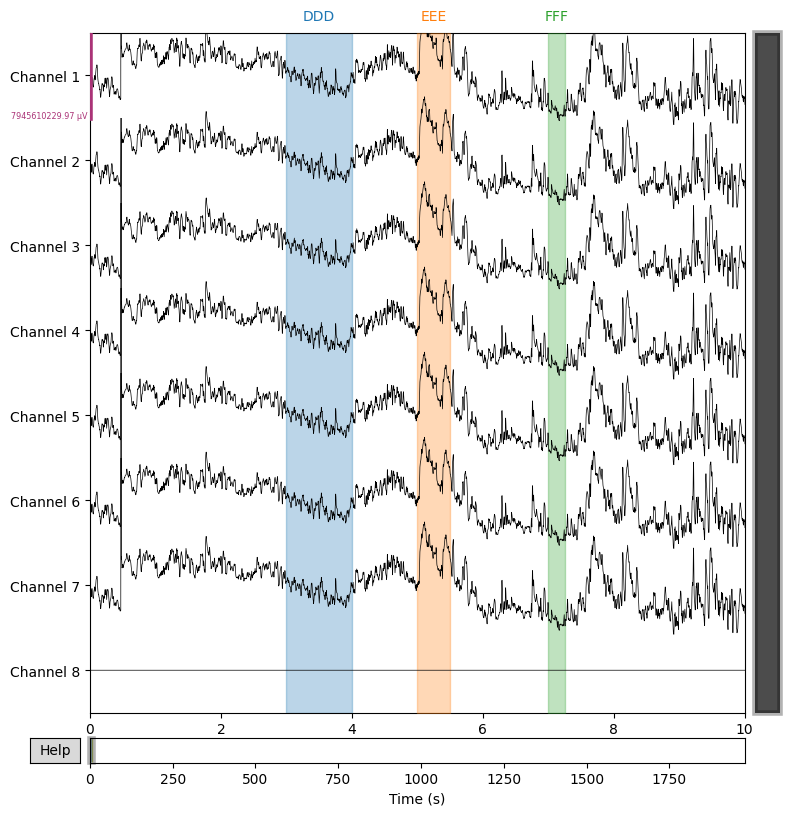

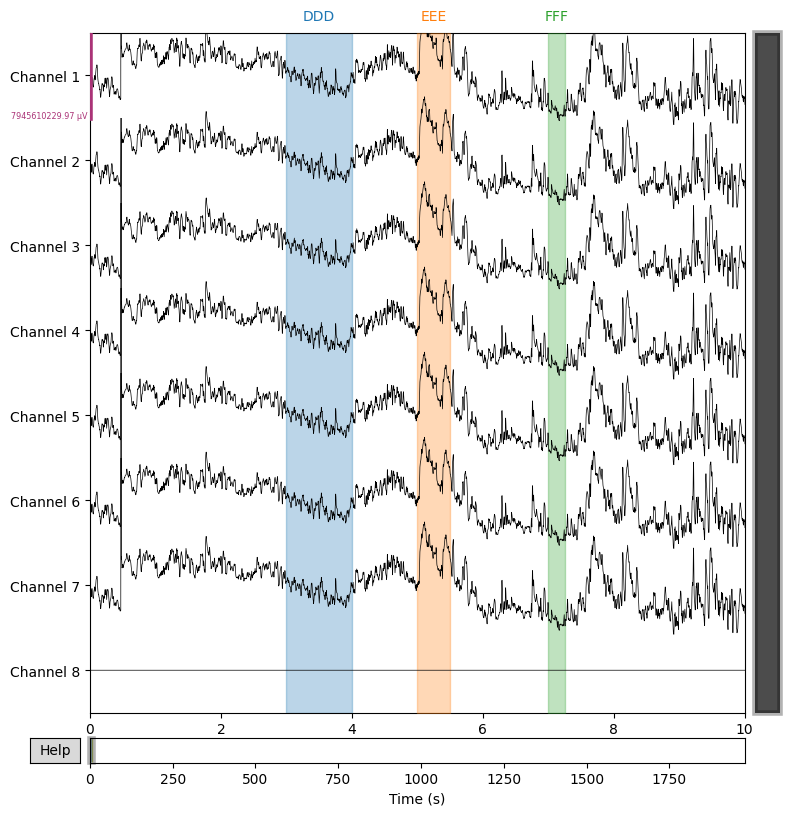

In [ ]:
#debugging
print("EEG data time range: 0 to", raw.times[-1], "seconds")  #how long the experiment was in seconds
print("Annotations in raw2:", raw2.annotations)               #list of the annotations
print("Adjusted onsets:", raw2.annotations.onset)             #the adjusted onsets
raw2.plot(start=0, duration=10, scalings='auto', block=True)  # Adjust start and duration as needed

Effective window size : 8.031 (s)


Plotting power spectral density (dB=True).


C:\Users\AarPi\AppData\Local\Temp\ipykernel_17524\128355210.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmin=0,fmax=50).plot()  #plot before filtering
C:\Users\AarPi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


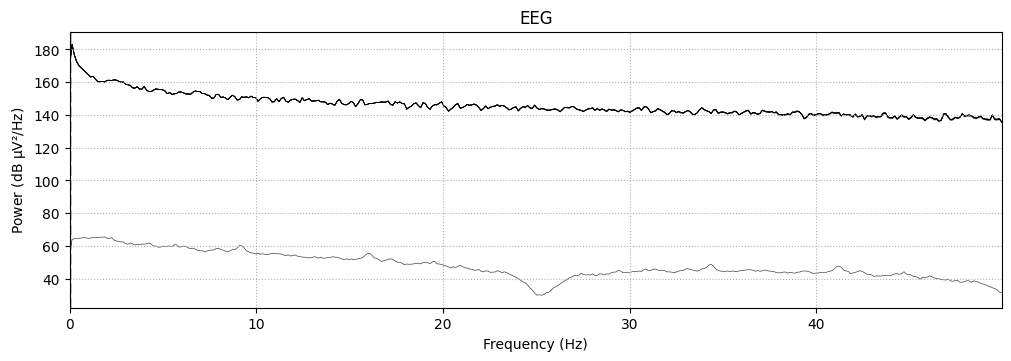

In [5]:
### Step 2. Filtering ####
raw.compute_psd(fmin=0,fmax=50).plot()  #plot before filtering


In [6]:
#setting high and low band pass filter
f_low = 0.1
f_high = 30
raw_cleaned = raw.filter(f_low, f_high, fir_design="firwin", skip_by_annotation="edge")   
#low and high pass filter, fir_design can be changed to match what lit review did

#notch filter for electrical noise
raw_cleaned.notch_filter(60)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8415 samples (33.000 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband e

<RawArray | 8 x 504527 (1978.5 s), ~30.8 MiB, data loaded>

Effective window size : 8.031 (s)
Plotting power spectral density (dB=True).


C:\Users\AarPi\AppData\Local\Temp\ipykernel_17524\2183862732.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_cleaned.compute_psd(fmin=0,fmax=50).plot()
C:\Users\AarPi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


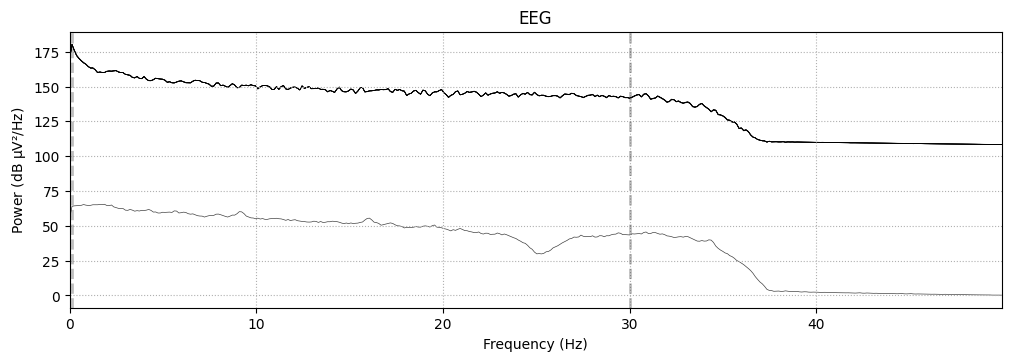

In [7]:
#new plot
raw_cleaned.compute_psd(fmin=0,fmax=50).plot()

In [8]:
### Selecting Non - Noisy Data
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")  
#pass in our raw file with all our eeg files
#exclude "bads" discards what signal are identified as bad. 
  #this does a lot of work for us

In [9]:
## ICA ##

#TO - DO: determine how many components there are, use 8 for now
ica = ICA(n_components=8, random_state=97, method="fastica")

ica.fit(raw_cleaned)   
#raw cleaned has been through filtering
#clean will have gone through ica

raw_clean = ica.apply(raw_cleaned)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components
Fitting ICA took 0.2s.
Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


C:\Users\AarPi\AppData\Local\Temp\ipykernel_1264\2535494896.py:6: RuntimeWarning: Using n_components=8 (resulting in n_components_=8) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.9) and smallest (9.9e-14) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 4
  ica.fit(raw_cleaned)


In [ ]:
### Event based epoching ###
tmin, tmax = -0.2, 1
#this is a window of time around each event 

event_epochs = Epochs(
    raw_clean,                   # Variable that contains our data
    event_id=["hands", "feet"],  # Events we want to investigate, remember we changed T1 and T2 to this
    tmin=tmin,                   # Start time relative to event, creating a buffer of how many seconds around event we want
    tmax=tmax,                   # End time relative to event
    proj=True,                   # Re-references data after everything we've done so far
    picks=picks,                 # Only use channels specified in 'picks' (AKA EEG)
    baseline=None,               # No baseline correction
    preload=True                 # Load the epochs into memory for faster access
)